<a href="https://colab.research.google.com/github/stefsyrsiri/Deep-Learning-Project/blob/dataset-exploration/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In progress** Deep learning project for the "Deep Learning" course of the MSc "Data Science".

Working with Anna! :)

In [ ]:
# Project overview
# 1. SVM
# 2. CNN
# 3. Transfer learning

In [ ]:
# Import packages
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
torch.manual_seed(42)

In [ ]:
# Datasets
# We have 2 candidate datasets with real and synthetic images
# CIFAKE: Real and AI-Generated Synthetic Images
# https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
#
# ArtiFact (no kaggle url - only kaggle API)
# !kaggle datasets download -d awsaf49/artifact-dataset
# We should also import and take a look at ArtiFact to see which dataset we prefare
# Took a look at ArtiFact. Much much bigger dataset with a lot datasets inside. Let's work with the simpler dataset first and try the other one if we have enough time.
#
# Using a kaggle key for now. Also using an input function to avoid storing the key in the code
# Whoever wants to run their code has to input their own key (Stef/Anna/TG) - we can change this later
KAGGLE_USERNAME = input("Enter your Kaggle username: ")
KAGGLE_KEY = input("Enter your Kaggle key: ")

os.environ['KAGGLE_USERNAME'] = KAGGLE_USERNAME
os.environ['KAGGLE_KEY'] = KAGGLE_KEY

In [ ]:
# Download CIFAKE dataset
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

In [27]:
# Unzip downloaded dataset (can be found in the Files on the left)
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip

In [29]:
!ls

cifake-real-and-ai-generated-synthetic-images.zip  sample_data	test  train


In [30]:
!find . -type d

.
./.config
./.config/configurations
./.config/logs
./.config/logs/2024.04.04
./train
./train/FAKE
./train/REAL
./test
./test/FAKE
./test/REAL
./sample_data


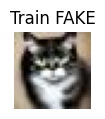

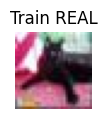

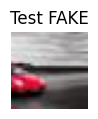

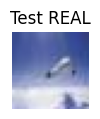

In [2]:
# Paths to the dataset
train_fake_path = './train/FAKE'
train_real_path = './train/REAL'
test_fake_path = './test/FAKE'
test_real_path = './test/REAL'

# Function to display an image
def show_image(title, path):
    image_files = os.listdir(path)
    img_path = os.path.join(path, image_files[0])  # Just take the first image for now
    img = Image.open(img_path)

    plt.figure(figsize=(1, 1))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()

# Show one image from each category
show_image('Train FAKE', train_fake_path)
show_image('Train REAL', train_real_path)
show_image('Test FAKE', test_fake_path)
show_image('Test REAL', test_real_path)

In [5]:
# Classes' labels
LABELS = np.asarray(os.listdir('train'))
print(LABELS)

['FAKE' 'REAL']


In [7]:
# Create the training and test datasets with ImageFolder class from PyTorch in comparison to creating custom datasets
# TODO: Add transformation
# Training dataset
train_dataset = datasets.ImageFolder(root='train') # 'train' is the name of the folder (also its path)
print(f"Training set:\n{train_dataset}\n")

# Validation dataset
valid_dataset = datasets.ImageFolder(root='test')
print(f"Validation set:\n{valid_dataset}")

Training set:
Dataset ImageFolder
    Number of datapoints: 100000
    Root location: train

Validation set:
Dataset ImageFolder
    Number of datapoints: 20000
    Root location: test


In [9]:
# Batch size - change if we get an Out Of Memory error
BATCH_SIZE = 64

# Training data loaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, # Shuffle for every epoch
    num_workers=2, pin_memory=True # Changed num_workers to 2 from 4 after warning
)
# Validation data loaders
valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, # No need to shuffle the validation set
    num_workers=2, pin_memory=True
)

In [ ]:
# Feature engineering

In [ ]:
# SVM

In [21]:
# Neural net architecture
# TG said that we should save our classes to another file and import them for the report
class DummyClassifier(nn.Module):
    def __init__(self):
        super(DummyClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = DummyClassifier()

In [ ]:
# Transfer learning